In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session= Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
first_date=session.query(Measurement.date).first()
print(f"The first date in the data set was in 2010 {first_date}")

The first date in the data set was in 2010 ('2010-01-01',)


In [10]:
#Query to find the last date
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date

('2017-08-23')

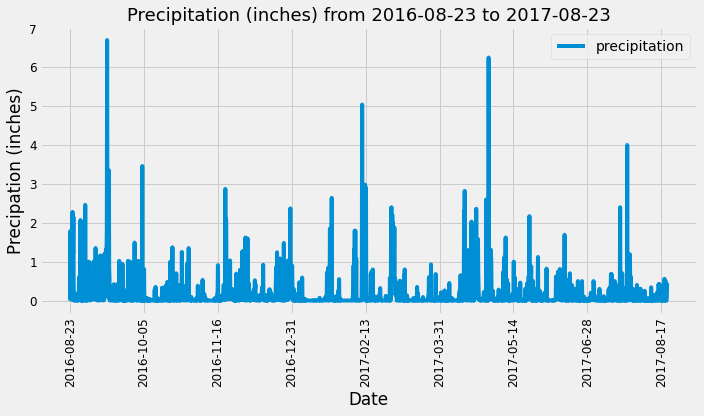

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
#last_date
# --- convert string date to date format for use with datetime library ---
date2 = (dt.datetime.strptime(last_date, "%Y-%m-%d")).date()
date365 = date2 - dt.timedelta(days=365)
#date365

# Perform a query to retrieve the data and precipitation scores
prec_data = session.query(Measurement.date, Measurement.prcp).\
            filter(Measurement.date >= date365).all()
#prec_data

# Save the query results as a Pandas DataFrame and set the index to the date column
prec_df = pd.DataFrame(prec_data, columns = ["date", "prcp"])
prec_df.set_index("date", inplace=True)


# Sort the dataframe by date - add the rename here as well
sort_df = prec_df.sort_values(["date"]).\
        rename(columns={"prcp":"precipitation"})


#drop missing values
sort_df = sort_df.dropna()
#sort_na.head()



# Use Pandas Plotting with Matplotlib to plot the data
sort_df.plot(figsize=(10,6), fontsize=12, rot=90)
plt.title(f"Precipitation (inches) from {date365} to {last_date}", fontsize=18)
plt.xlabel("Date")
plt.ylabel("Precipation (inches)")
plt.tight_layout()
plt.show()

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
sort_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number stations in the dataset
stations = session.query(Station).count()
print(f"There are total of {stations} stations")

There are total of 9 stations


In [16]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
total_stations = session.query(Measurement.station, func.count(Measurement.station)).\
                        order_by(func.count(Measurement.station).desc()).\
                        group_by(Measurement.station).all()
total_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active = total_stations[0]
#('USC00519281', 2772)
most_active = total_stations[0][0]
print(f"The most active station has a username of {most_active}")

#Lowest temperature
lowest = session.query(func.min(Measurement.tobs)).\
        filter(Measurement.station==most_active).scalar()
print(f"Lowest temperature is: {lowest} degrees Fahrenheit.")

#highest temperature
highest = session.query(func.max(Measurement.tobs)).\
        filter(Measurement.station==most_active).scalar()
print(f"Highest temperature is: {highest} degrees Fahrenheit.")

#average temperature
average = session.query(func.avg(Measurement.tobs)).\
        filter(Measurement.station==most_active).scalar()
print(f"Average temperature is: {round(average, 2)} degrees Fahrenheit.")

The most active station has a username of USC00519281
Lowest temperature is: 54.0 degrees Fahrenheit.
Highest temperature is: 85.0 degrees Fahrenheit.
Average temperature is: 71.66 degrees Fahrenheit.


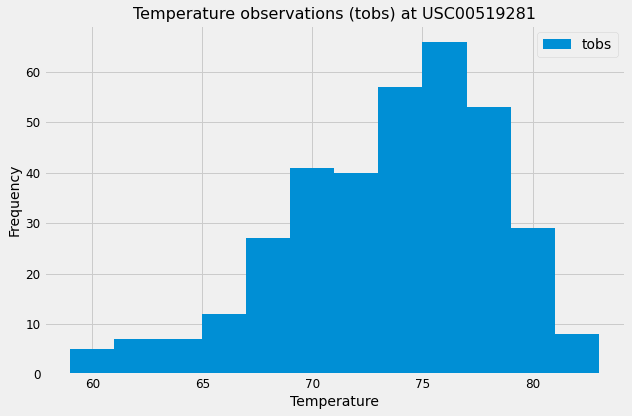

In [18]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# --- create a dataframe from temp observations in last 12 months at most active station ---
temp_data = pd.DataFrame(session.query(Measurement.tobs).\
                                filter((Measurement.station == most_active)\
                                        & (Measurement.date >= date365)\
                                        & (Measurement.date <= date2)).all())

temp_data.plot(kind="hist", figsize=(9,6), bins=12, legend=True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Temperature", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title(f"Temperature observations (tobs) at {most_active}", fontsize=16)

plt.tight_layout()
plt.show()
                         

# Close session

In [19]:
# Close Session
session.close()